# Enumerate amines

16th May

This notebook is for converting Enamine amines into isocyanides and then enumerating them against the previous library.

Let's decompose the best molecule first

In [1]:
from rdkit import Chem  
from dock2hit.library_generation.decompose_ugi import decompose_ugi_molecule_into_components

best_ugi_mol = 'CC(C)Oc1ccc(cc1)N(C(C(=O)NCCc1ccns1)c1cccnc1)C(=O)c1cocn1'
components = decompose_ugi_molecule_into_components(best_ugi_mol)
print(components)

INFO:rdkit:Enabling RDKit 2021.09.4 jupyter extensions


['O=C(O)c1cocn1', 'CC(C)Oc1ccc(N)cc1', 'O=Cc1cccnc1', '[C-]#[N+]CCc1ccns1']


Check that the components make sense

In [2]:
import mols2grid

mols = [Chem.MolFromSmiles(x) for x in [best_ugi_mol]+components]
mols2grid.display(mols)

Highlight substructures

((1, 0, 2),)


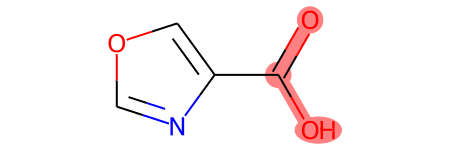

In [3]:
from rdkit.Chem.Draw import IPythonConsole

acid = mols[1]
substructure = Chem.MolFromSmarts('C(=O)O')
print(acid.GetSubstructMatches(substructure))
acid


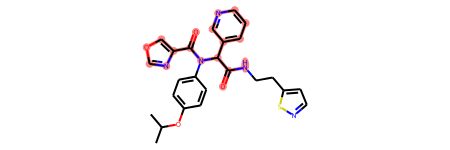

In [22]:
best_substructure = Chem.MolFromSmarts(
    '[NX3](C([C:1](=O)[NX3;H1])c1cccnc1)C(=O)c1cocn1')
best_mol = mols[0]
best_mol.GetSubstructMatches(best_substructure)
best_mol


In [27]:
from rdkit.Chem import rdChemReactions

def replace_isocyanide() -> rdChemReactions.ChemicalReaction:

    best_mol_substruct = '[NX3]([*:1])(C([C:2](=O)[NX3;H1])c1cccnc1)C(=O)c1cocn1'
    amine_smarts = '[NX3;!$(N*=*):3]([H:4])[*:5]'

    new_ugi_smarts = '[NX3]([*:1])(C([C:2](=O)[N:3][*:5])c1cccnc1)C(=O)c1cocn1'
    replace_isocyanide_smarts = f'{best_mol_substruct}.{amine_smarts}>>{new_ugi_smarts}'
    replacement_rxn = rdChemReactions.ReactionFromSmarts(replace_isocyanide_smarts)

    return replacement_rxn

In [10]:
from rdkit.Chem import PandasTools

enamine_dir = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/'
primary_sdf = enamine_dir + 'Enamine_Primary_Amines_37221cmpds_20220404.sdf'
secondary_sdf = enamine_dir + 'Enamine_Secondary_Amines_25592cmpds_20220404.sdf'

df_primary = PandasTools.LoadSDF(
    primary_sdf, smilesName='SMILES', molColName='mol')[['ID', 'SMILES', 'mol']].head()


In [26]:
replacement_rxn = replace_isocyanide()

new_ugis = [best_mol]
for amine in df_primary.SMILES:
    reactants = tuple([Chem.AddHs(reactant) for reactant in [best_mol, Chem.MolFromSmiles(amine)]])

    possible_products = replacement_rxn.RunReactants(reactants)
    # for product in possible_products:
    product = Chem.RemoveHs(possible_products[0][0])
    # product.GetSubstructMatches(best_substructure)
    new_ugis.append(product)
    
mols2grid.display(new_ugis)


Convert them into individual lists of rdkit mols for input to library generation

In [4]:
components_as_mols = [Chem.MolFromSmiles(x) for x in components]

best_acid = [components_as_mols[0]]
best_amine = [components_as_mols[1]]
best_aldehyde = [components_as_mols[2]]
best_isocyanide = [components_as_mols[3]]

Load Enamine amines:

In [5]:
from rdkit.Chem import PandasTools

enamine_dir = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/'
primary_sdf = enamine_dir + 'Enamine_Primary_Amines_37221cmpds_20220404.sdf'
secondary_sdf = enamine_dir + 'Enamine_Secondary_Amines_25592cmpds_20220404.sdf'

df_amines = PandasTools.LoadSDF(
    primary_sdf, smilesName='SMILES', molColName='mol')[['ID', 'SMILES', 'mol']]
df_secondary = PandasTools.LoadSDF(
    secondary_sdf, smilesName='SMILES', molColName='mol')[['ID', 'SMILES', 'mol']]
df_amines = pd.concat([df_amines, df_secondary])
df_amines.head()

In [5]:

from typing import Union

from fire import Fire
from tqdm import tqdm
import pandas as pd
from rdkit import Chem
from rdkit.Chem.rdchem import Mol
from rdkit.Chem import PandasTools
from rdkit.Chem import rdChemReactions
from useful_rdkit_utils import add_molecule_and_errors

from dock2hit.library_generation.decompose_ugi import decompose_ugi_molecule_into_components
from dock2hit.library_generation.enumerate_ugi import generate_ugi_library


def replace_isocyanide() -> rdChemReactions.ChemicalReaction:

    best_mol_substruct = '[NX3]([*:1])(C([C:2](=O)[NX3;H1])c1cccnc1)C(=O)c1cocn1'
    amine_smarts = '[NX3;!$(N*=*):3]([H:4])[*:5]'

    new_ugi_smarts = '[NX3]([*:1])(C([C:2](=O)[N:3][*:5])c1cccnc1)C(=O)c1cocn1'
    replace_isocyanide_smarts = f'{best_mol_substruct}.{amine_smarts}>>{new_ugi_smarts}'
    replacement_rxn = rdChemReactions.ReactionFromSmarts(
        replace_isocyanide_smarts)

    return replacement_rxn


def replace_isocyanide_for_single_ugi(input_ugi_mol: Union[str, Mol],
                                      df_amine: pd.DataFrame,
                                      replacement_rxn: rdChemReactions.ChemicalReaction = None) -> pd.DataFrame:

    best_mol_substruct = Chem.MolFromSmarts(
        '[NX3]([*:1])(C([C:2](=O)[NX3;H1])c1cccnc1)C(=O)c1cocn1')
    amine_smarts = Chem.MolFromSmarts('[NX3;!$(N*=*):3]([H:4])[*:5]')

    if replacement_rxn is None:
        replacement_rxn = replace_isocyanide()

    if isinstance(input_ugi_mol, str):
        input_ugi_mol = Chem.MolFromSmiles(input_ugi_mol)

    df_this_ugi = df_amine.copy()

    input_ugi_mol = Chem.AddHs(input_ugi_mol)
    for index, amine_row in df_this_ugi.iterrows():
        print(input_ugi_mol.GetSubstructMatches(best_mol_substruct))
        print(Chem.AddHs(amine_row.mol).GetSubstructMatches(amine_smarts))

        reactants = tuple([input_ugi_mol, Chem.AddHs(amine_row.mol)])

        possible_products = replacement_rxn.RunReactants(reactants)
        # print(possible_products)
        product = Chem.RemoveHs(possible_products[0][0])
        df_this_ugi.loc[index, 'ugi'] = Chem.MolToSmiles(product)

    return df_this_ugi


def enumerate_isocyanides_for_library_of_ugis(input_smiles_file: str,
                                              output_file: str,
                                              test: bool = False):
    df_ugis = pd.read_csv(input_smiles_file)

    if test:
        df_ugis = df_ugis.head()

    add_molecule_and_errors(df_ugis, smiles_col='ugi', mol_col_name='mol')

    replacement_rxn = replace_isocyanide()
    enamine_dir = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/'
    primary_sdf = enamine_dir + 'Enamine_Primary_Amines_37221cmpds_20220404.sdf'
    secondary_sdf = enamine_dir + 'Enamine_Secondary_Amines_25592cmpds_20220404.sdf'

    df_amines = PandasTools.LoadSDF(
        primary_sdf, idName='rdkit_ID', smilesName='SMILES', molColName='mol')[['ID', 'SMILES', 'mol']]

    if test:
        df_amines = df_amines.head()
    else:
        df_secondary = PandasTools.LoadSDF(
            secondary_sdf, idName='rdkit_ID', smilesName='SMILES', molColName='mol')[['ID', 'SMILES', 'mol']]
        df_amines = pd.concat([df_amines, df_secondary])

    df_amines = df_amines.rename(
        columns={'ID': 'ID_x', 'SMILES': 'SMILES_x'})

    df_new_lib = []
    for index, ugi_row in tqdm(df_ugis.iterrows(), total=len(df_ugis)):

        df_this_ugi = replace_isocyanide_for_single_ugi(
            ugi_row['mol'], df_amines, replacement_rxn)
        df_this_ugi['ID_y'] = ugi_row['ID']
        df_this_ugi['SMILES_y'] = ugi_row['SMILES']
        df_new_lib.append(df_this_ugi)

    df_new_lib = pd.concat(df_new_lib)
    df_new_lib.dropna().drop(columns=['mol']).to_csv(output_file, index=False)
    print(
        f'Ugi library generated, original length {len(df_amines)}, final length: {len(df_new_lib)}')
    return    

input_smiles = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/enumerated_primary_amine_library.csv'
output = 'tmp.csv'
enumerate_isocyanides_for_library_of_ugis(input_smiles, output, test=True)


((7, 6, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 8, 9, 10, 11, 12, 13, 14),)
((0, 11, 1), (0, 11, 12), (0, 12, 1))
((7, 6, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 8, 9, 10, 11, 12, 13, 14),)
((17, 34, 16), (17, 34, 35), (17, 35, 16))
((7, 6, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 8, 9, 10, 11, 12, 13, 14),)
((0, 11, 1), (0, 11, 12), (0, 12, 1))
((7, 6, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 8, 9, 10, 11, 12, 13, 14),)
((0, 9, 1), (0, 9, 10), (0, 10, 1))
((7, 6, 15, 16, 17, 18, 26, 27, 28, 29, 30, 31, 8, 9, 10, 11, 12, 13, 14),)
((0, 16, 1), (0, 16, 17), (0, 17, 1))
((17, 16, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 18, 19, 20, 21, 22, 23, 24),)
((0, 11, 1), (0, 11, 12), (0, 12, 1))
((17, 16, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 18, 19, 20, 21, 22, 23, 24),)
((17, 34, 16), (17, 34, 35), (17, 35, 16))
((17, 16, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 18, 19, 20, 21, 22, 23, 24),)
((0, 11, 1), (0, 11, 12), (0, 12, 1))
((17, 16, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 18, 19, 20, 21, 22

100%|██████████| 5/5 [00:00<00:00, 150.96it/s]


Too memory intensive so submitting a job instead

In [8]:
import os
from dock2hit.utils import write_slurm_script

input_smiles = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/enumerated_primary_amine_library.csv'
save_path = '/rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/enumerated_isocyanide_library.csv'

current_dir = os.getcwd()

script = f'python {current_dir}/generate_ugi_library_from_isocyanides.py --input_smiles_file={input_smiles} --output_file={save_path}'


file_name = 'subm_ugi_iso_gen'
run_time = '0:15:00'
output_name = f'{current_dir}/{file_name}.out'
gpu = False
write_slurm_script(job_name=f'{file_name}',
                   run_time=f'{run_time}',
                   output_name=output_name,
                   package_dir='/rds-d2/user/wjm41/hpc-work/datasets/Ugis/',
                   script=script,
                   args=[],
                   file_name=file_name,
                   email=True,
                   gpu=gpu
                   )

print(f"Submitted ugi generation CPU job saving output to {save_path}")

!sbatch {file_name}


Submitted ugi generation CPU job saving output to /rds-d2/user/wjm41/hpc-work/datasets/Ugis/datasets/enamine_library_generation/enumerated_isocyanide_library.csv
Submitted batch job 61273190
